In [4]:
import numpy as np
import pandas as pd
from numba import jit

import matplotlib.pyplot as plt

from colorcet import palette
import datashader as ds
import datashader.colors as dc
import datashader.utils as utils
from datashader import transfer_functions as tf

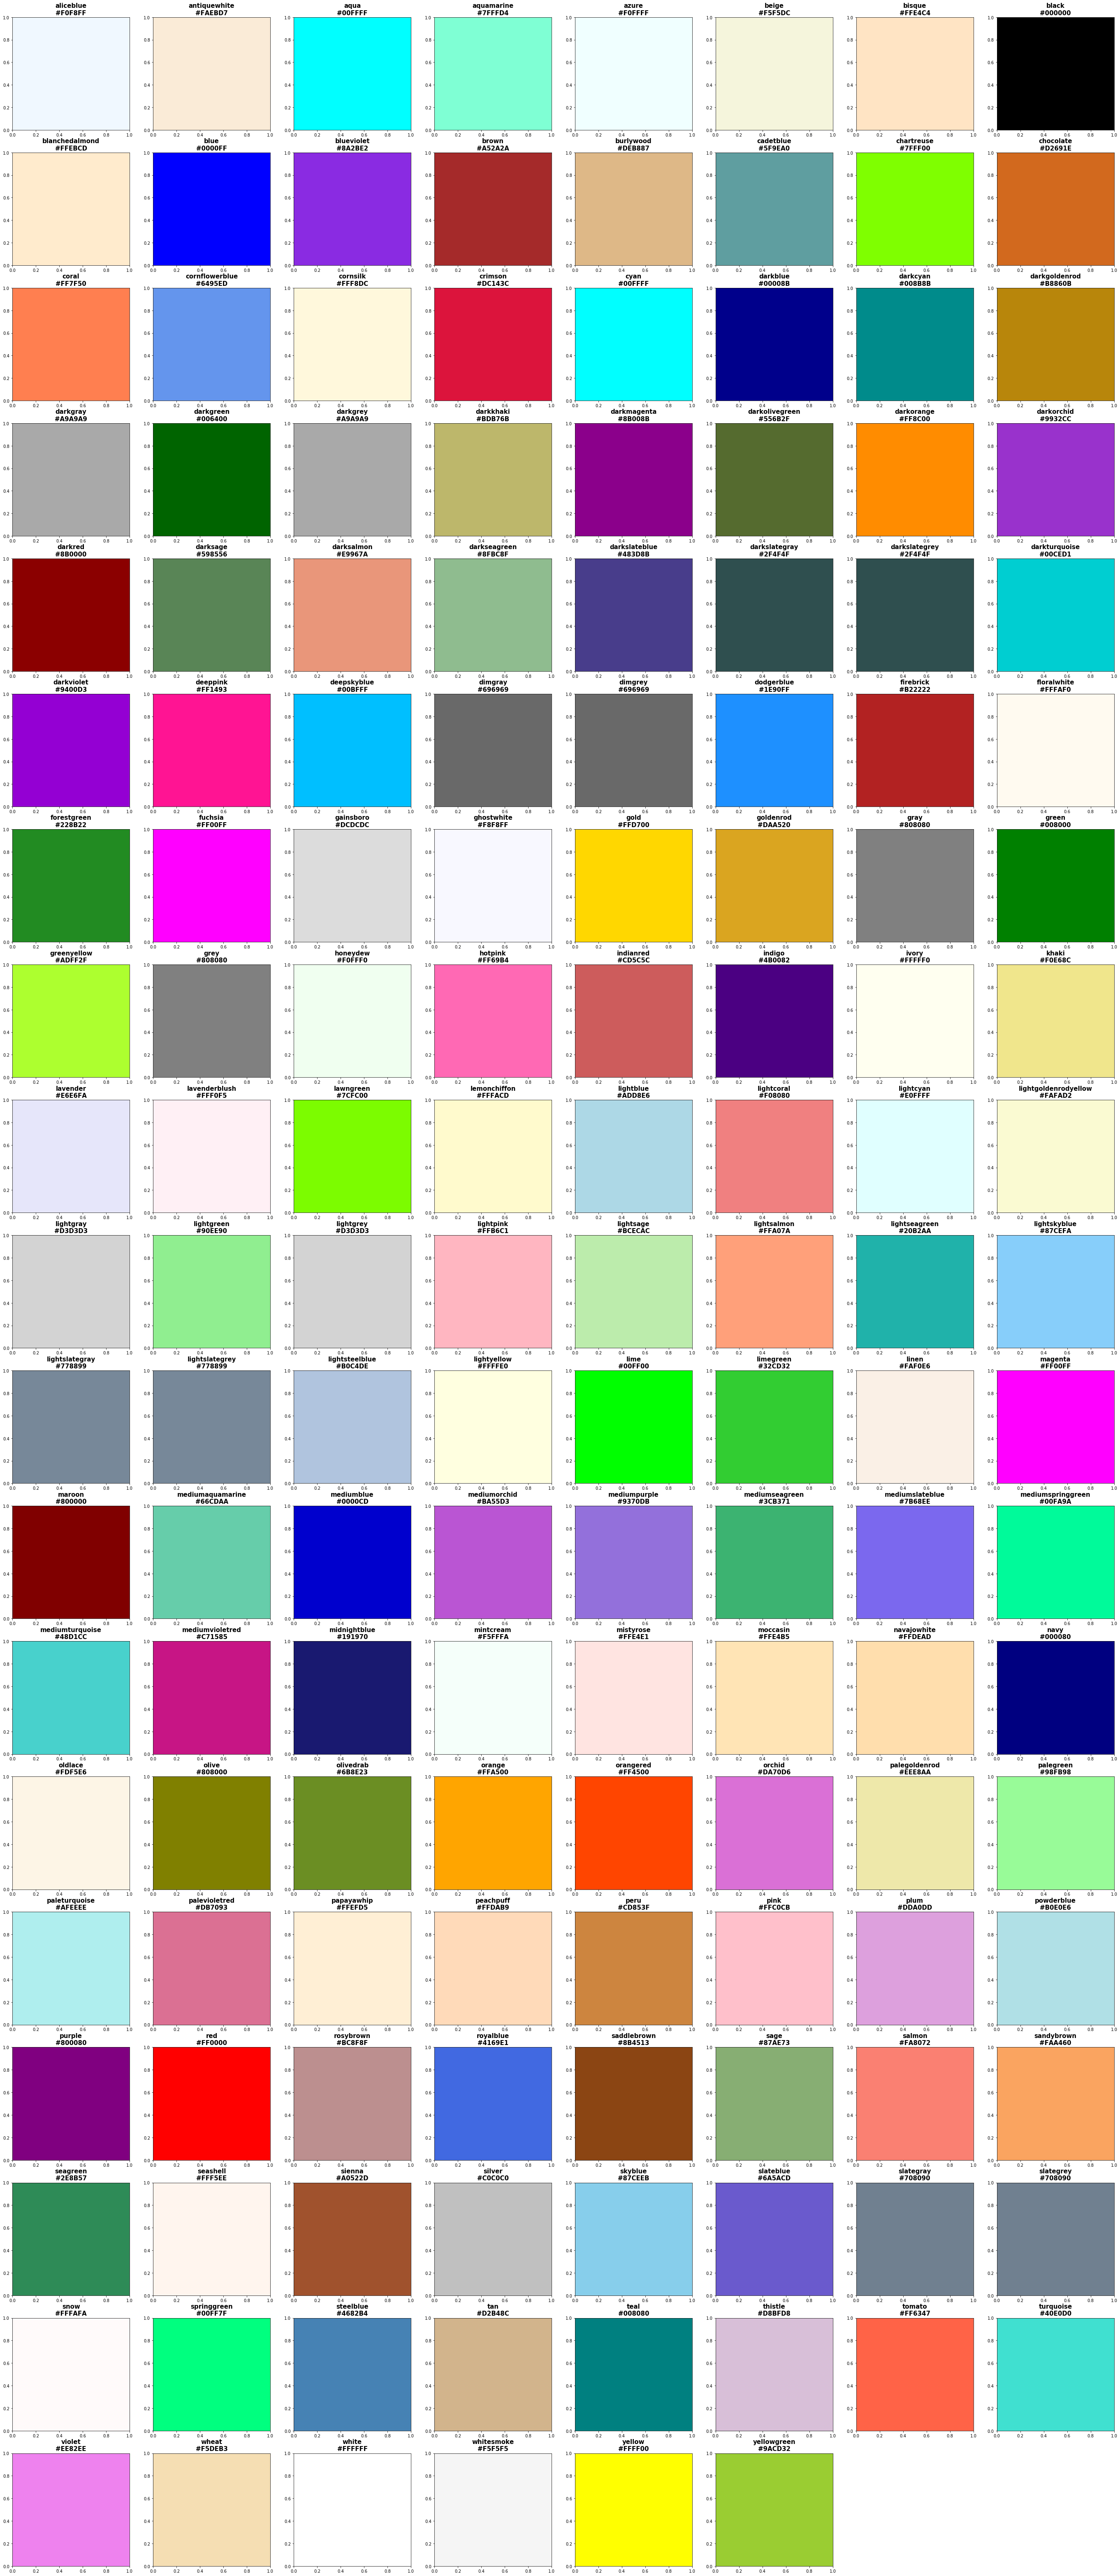

In [5]:
color_keys = list(dc.color_lookup)
color_values = [dc.color_lookup[key] for key in color_keys]

num_of_colors = len(color_keys)

ncols = 8
nrows = num_of_colors // ncols + 1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*6, nrows*6))

titlesize = 15

for idx, color in enumerate(color_values):
    x = idx // ncols
    y = idx % ncols
    axes[x][y].set_facecolor(color)
    axes[x][y].set_title('{0}\n{1}'.format(color_keys[idx], color), fontsize=titlesize, fontweight='bold')

for idx in range(num_of_colors, nrows*ncols):
    x = idx // ncols
    y = idx % ncols
    axes[x][y].axis('off')

plt.show()

## Define attractors

In [ ]:
@jit(nopython=True)
def Clifford(x, y, a, b, c, d, *o):

    return np.sin(a * y) + c * np.cos(a * x), \
           np.sin(b * x) + d * np.cos(b * y)

In [ ]:
@jit(nopython=True)
def Symmetric_Icon(x, y, a, b, g, om, l, d, *o):
    zzbar = x*x + y*y
    p = a*zzbar + l
    zreal, zimag = x, y
    
    for i in range(1, d-1):
        za, zb = zreal * x - zimag * y, zimag * x + zreal * y
        zreal, zimag = za, zb
    
    zn = x*zreal - y*zimag
    p += b*zn
    
    return p*x + g*zreal - om*y, \
           p*y - g*zimag + om*x

In [ ]:
@jit(nopython=True)
def Ikeda(x, y, u, *o):
    
    t = 0.4 - 6/(1 + x*x + y*y)
    
    return 1 + u * (x * np.cos(t) - y * np.sin(t)), \
           u * (x * np.sin(t) + y * np.cos(t))

In [ ]:
@jit(nopython=True)
def Fractal_Dream(x, y, a, b, c, d, *o):
    """
    x and y both should start at 0.1
    Variables a and b are floating point values bewteen -3 and +3
    Variables c and d are floating point values between -0.5 and +1.5
    """
    return np.sin(y * b) + c * np.sin(x * b), \
           np.sin(x * a) + d * np.sin(y * a)

## Calculating trajectories for choosen attractor

In [ ]:
@jit(nopython=True)
def trajectory_coords(att, x0, y0, a, b=0, c=0, d=0, e=0, f=0, n=1e07):
    x = np.zeros(n)
    x[0] = x0
    
    y = np.zeros(n)
    y[0] = y0

    for i in np.arange(n-1):
        x[i+1], y[i+1] = att(x[i], y[i], a, b, c, d, e, f)

    return x, y

def trajectory(att, x0, y0, a, b=0, c=0, d=0, e=0, f=0, n=1e07):
    
    x, y = trajectory_coords(att, x0, y0, a, b, c, d, e, f, n)
    
    return pd.DataFrame(dict(x=x, y=y))

In [ ]:
def plot(att, x0, y0, a, b=0, c=0, d=0, e=0, f=0, n=1e07, figscale=2e03, cmap=dc.viridis):
    # Create attractor
    df = trajectory(att, x0, y0, a, b, c, d, e, f, n=int(n))

    cvs = ds.Canvas(plot_width=int(figscale), plot_height=int(figscale))
    agg = cvs.points(df, 'x', 'y')
    ds.transfer_functions.Image.border=0
    img = tf.set_background(tf.shade(agg, cmap=cmap),'midnightblue')
    utils.export_image(img=img, filename=('./out/{0}_{1}_{2}_{3}_{4}_{5}_{6}_{7}'.format(att.__name__, a, b, c, d, e, f, n)))

    return img

In [ ]:
img = plot(att=Clifford, x0=0, y0=0, a=1.0, b=-1.5, c=1.2, d=-2.3, e=0, f=0, n=1e07, figscale=2e03)
img

In [ ]:
# 0.01, 0.01, 5.0, -1.0, 1.0, 0.188, -2.5, 5
img = plot(att=Symmetric_Icon, x0=0.01, y0=0.01, a=3.5, b=-2.87, c=1.5, d=0.133, e=-2.23, f=4, n=1e07, figscale=2e03)
img

In [ ]:
img = plot(att=Ikeda, x0=0, y0=0, a=0.90102, b=0, c=0, d=0, e=0, f=0, n=1e07, figscale=2e03)
img

In [ ]:
# Examples:
# x0=0.1, y0=0.1, a=-0.966918, b=2.879879, c=0.765145, d=0.744728, e=0, f=0
img = plot(att=Fractal_Dream, x0=0.1, y0=0.1, a=-0.966918, b=2.879879, c=0.765145, d=0.744728, e=0, f=0,
           n=5e08, figscale=2e03, cmap=)
img